<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


<AxesSubplot: >

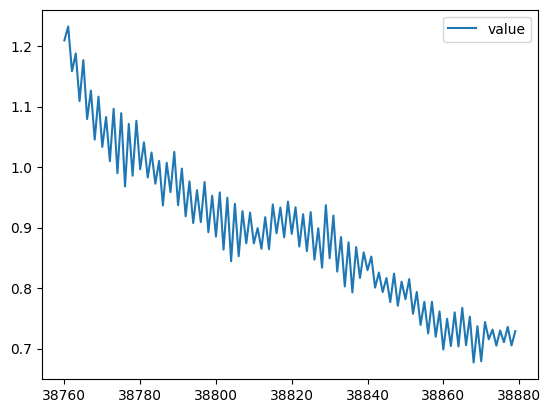

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_588044/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 11.520908569688338 %
smape 6.592341580956478 %
smape 4.942163440959844 %
smape 4.139809288868779 %
smape 4.084112346771429 %
smape 3.896191292796393 %
smape 3.81521077281986 %
smape 3.743034816559469 %
smape 3.6862058030190874 %
smape 3.6523819304131275 %
smape 3.602075170050239 %
smape 3.589272117895777 %
smape 3.547785809176446 %
smape 3.529879634502774 %
smape 3.4956505988882474 %
smape 3.490719261650018 %
smape 3.495447027785649 %
smape 3.476913310587406 %
smape 3.467653813548604 %
smape 3.430664628656984 %
smape 3.4206002712119044 %
smape 3.4582530576953587 %
smape 3.4241852548234815 %
smape 3.4291470221826557 %
smape 3.378103586589122 %
smape 3.38925760375521 %
smape 3.4231287413630747 %
smape 3.4021425102864615 %
smape 3.4019173053774048 %
smape 3.349992141334547 %
smape 3.3874980935946715 %
smape 3.416299476936372 %
smape 3.420926531155904 %
smape 3.3400096583632175 %
smape 3.3683256301157485 %
smape 3.4101107255256142 %
smape 3.3560684616323453 %
smape 3.360896786478789 

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 1.3727595612581354 %
SMAPE 1.0792853476523305 %
SMAPE 0.33572680134193433 %
SMAPE 0.7705667617701693 %
SMAPE 0.5550861892590433 %
SMAPE 0.33093655235279584 %
SMAPE 0.19099375802761642 %
SMAPE 0.18618677515860327 %
SMAPE 0.585728908488818 %
SMAPE 1.3079188227093255 %
SMAPE 1.354980904488798 %
SMAPE 1.8053118944499145 %
SMAPE 2.225505065791367 %
SMAPE 0.582499318135433 %
SMAPE 0.11964112344321619 %
SMAPE 0.773269865407201 %
SMAPE 0.1869697850497687 %
SMAPE 0.3081770218645943 %
SMAPE 0.20076818486268166 %
SMAPE 0.17138091167589664 %
SMAPE 0.11695537315517869 %
SMAPE 0.6314254857894639 %
SMAPE 0.8672412831447217 %
SMAPE 0.8899640963445563 %
SMAPE 0.985243801107572 %
SMAPE 0.7271740573305578 %
SMAPE 0.5876179507486086 %
SMAPE 0.6282782714570203 %
SMAPE 0.13816062220939784 %
SMAPE 0.4291870865731653 %
SMAPE 0.914826768797866 %
SMAPE 0.17532831646167324 %
SMAPE 1.739238250022936 %
SMAPE 1.957002073249896 %
SMAPE 0.37685015127681254 %
SMAPE 1.3904586966054922 %
SMAPE 1.1297224670925061 %

SMAPE 0.17615855631083832 %
SMAPE 1.5737354644461448 %
SMAPE 0.24560853766143967 %
SMAPE 0.6044023290687619 %
SMAPE 0.3746946911296618 %
SMAPE 0.10994029433641116 %
SMAPE 0.549057124848332 %
SMAPE 0.29262679524254054 %
SMAPE 0.8767368818621436 %
SMAPE 0.34231655504777336 %
SMAPE 1.2429162579828699 %
SMAPE 0.06494520479282073 %
SMAPE 0.4249741037313015 %
SMAPE 0.33150782842130866 %
SMAPE 0.0632031281493255 %
SMAPE 0.28723180448378116 %
SMAPE 0.9565717878540454 %
SMAPE 1.2220693653416674 %
SMAPE 0.15560075102985138 %
SMAPE 1.064385579957161 %
SMAPE 0.20360721457109318 %
SMAPE 0.21100372783985222 %
SMAPE 0.7629204603185826 %
SMAPE 1.1195386749286627 %
SMAPE 0.11107237192254617 %
SMAPE 0.4062294778832438 %
SMAPE 0.08401156914942476 %
SMAPE 0.539437548339265 %
SMAPE 0.22241561498488946 %
SMAPE 0.24485656061006014 %
SMAPE 0.8932133877242449 %
SMAPE 0.10833323400493101 %
SMAPE 0.07760350913940783 %
SMAPE 0.48484384060066077 %
SMAPE 0.10430725504338056 %
SMAPE 0.08592386128611906 %
SMAPE 0.986

SMAPE 0.12476734812798895 %
SMAPE 0.31681283268380867 %
SMAPE 0.23972938686256384 %
SMAPE 0.01796457271987606 %
SMAPE 0.09702079140288333 %
SMAPE 0.1545947671678789 %
SMAPE 0.4753445266451308 %
SMAPE 1.9783130956075183 %
SMAPE 0.16474069008063452 %
SMAPE 0.2834719517522899 %
SMAPE 0.02689116607649566 %
SMAPE 0.01721854186416749 %
SMAPE 0.1350036819349043 %
SMAPE 0.04713542296212836 %
SMAPE 0.022303239968437083 %
SMAPE 0.12344243867119076 %
SMAPE 0.10936706738198154 %
SMAPE 0.10256452561770858 %
SMAPE 0.2964423429666567 %
SMAPE 0.05493258339328121 %
SMAPE 0.07764394770788385 %
SMAPE 0.40339073569258227 %
SMAPE 0.3221313082512438 %
SMAPE 0.402675150991854 %
SMAPE 0.17914150706383225 %
SMAPE 0.9562810375464325 %
SMAPE 0.09980038780713586 %
SMAPE 0.23793088279035146 %
SMAPE 0.12500983685458777 %
SMAPE 0.06685785510842379 %
SMAPE 0.04723382271879473 %
SMAPE 0.1235844829508892 %
SMAPE 0.37550340647976554 %
SMAPE 0.5092596950780717 %
SMAPE 0.1316337064754407 %
SMAPE 0.3818844359338982 %
SMAPE

SMAPE 0.1419197878135492 %
SMAPE 1.811475882510422 %
SMAPE 0.22343669202388128 %
SMAPE 0.07929556025010243 %
SMAPE 0.10784808375743182 %
SMAPE 0.09445635831525578 %
SMAPE 0.21456608260058374 %
SMAPE 0.3525514413329347 %
SMAPE 0.043237545027068336 %
SMAPE 0.1467546597496039 %
SMAPE 0.051914031434535 %
SMAPE 0.08096475483398535 %
SMAPE 0.014511863665546796 %
SMAPE 0.3956284264295391 %
SMAPE 0.29766820108284264 %
SMAPE 0.031178675001115153 %
SMAPE 0.49532025036296545 %
SMAPE 0.5063971529766604 %
SMAPE 0.15538116760535559 %
SMAPE 1.4815527007649507 %
SMAPE 0.35538757173753766 %
SMAPE 0.534242500119035 %
SMAPE 0.04581101150367317 %
SMAPE 0.21225261521470884 %
SMAPE 0.08083247231479618 %
SMAPE 0.028516636414451572 %
SMAPE 0.5681260104502144 %
SMAPE 0.05760318889724658 %
SMAPE 0.36954298567627575 %
SMAPE 0.3425112109634938 %
SMAPE 0.02706686780607015 %
SMAPE 0.06828326636332349 %
SMAPE 0.0385153281958992 %
SMAPE 0.24301573229149653 %
SMAPE 0.349536545476667 %
SMAPE 0.4310188155695869 %
SMAPE 

SMAPE 0.026260462951540834 %
SMAPE 0.25228421101428466 %
SMAPE 0.03576604686531937 %
SMAPE 0.08952447210640457 %
SMAPE 0.07717276078744817 %
SMAPE 0.20854965026774153 %
SMAPE 0.07669538561322042 %
SMAPE 0.10514758761235043 %
SMAPE 0.18601865412051666 %
SMAPE 0.4608546048257267 %
SMAPE 0.9799385984115361 %
SMAPE 0.08766471366789119 %
SMAPE 0.2333534369208792 %
SMAPE 0.04317268299683974 %
SMAPE 0.239669688755157 %
SMAPE 0.5011129274880659 %
SMAPE 0.23096410021162228 %
SMAPE 0.03328938664628822 %
SMAPE 0.05158359370841481 %
SMAPE 0.06594557745927432 %
SMAPE 0.07539813687799324 %
SMAPE 0.2626947102239683 %
SMAPE 0.07374111662602445 %
SMAPE 0.331386448984631 %
SMAPE 0.22143360760492214 %
SMAPE 0.12239611969926045 %
SMAPE 0.46018639932299266 %
SMAPE 0.19441671890763246 %
SMAPE 0.07545141869195504 %
SMAPE 0.06713490540073508 %
SMAPE 0.42922915023791575 %
SMAPE 1.0580385498287797 %
SMAPE 0.2544966521600145 %
SMAPE 0.07854071775864213 %
SMAPE 0.31669564910498593 %
SMAPE 0.03709035007886996 %
SM

SMAPE 0.2867601497673604 %
SMAPE 0.45568821204506094 %
SMAPE 0.042757310910928936 %
SMAPE 0.10719813479863659 %
SMAPE 0.28356170078996 %
SMAPE 0.28884619039217796 %
SMAPE 0.93671442955565 %
SMAPE 0.9650296723284555 %
SMAPE 0.04257501629535909 %
SMAPE 0.29616979428431023 %
SMAPE 0.3766127391900227 %
SMAPE 0.11541039724761505 %
SMAPE 0.25988731553843536 %
SMAPE 29.8263428658247 %
SMAPE 8.36502051880234 %
SMAPE 12.154743610823061 %
SMAPE 16.79939187769196 %
SMAPE 7.5660510150773925 %
SMAPE 3.0771254038500047 %
SMAPE 0.38729020795108227 %
SMAPE 0.5459131995143025 %
SMAPE 0.19398454835123857 %
SMAPE 0.2747993261400552 %
SMAPE 0.3451732729336072 %
SMAPE 0.9420288609703675 %
SMAPE 0.13921707794735028 %
SMAPE 0.09408025422681021 %
SMAPE 0.3476936893639504 %
SMAPE 0.39374763253999845 %
SMAPE 0.15644026667814614 %
SMAPE 0.2497745006313039 %
SMAPE 0.3044338816889649 %
SMAPE 0.07389683457540741 %
SMAPE 0.6068860710156514 %
SMAPE 0.07875009438794223 %
SMAPE 0.21976256323478083 %
SMAPE 0.23200649935

SMAPE 1.2954511475654726 %
SMAPE 0.07091190892242594 %
SMAPE 0.03567021225160261 %
SMAPE 0.48328749115171377 %
SMAPE 0.21282122459535913 %
SMAPE 0.11641788577513522 %
SMAPE 0.5746883585543401 %
SMAPE 0.14723212937087737 %
SMAPE 0.25737700913038 %
SMAPE 0.04712002313499397 %
SMAPE 0.07623198156943545 %
SMAPE 0.26452665380975304 %
SMAPE 0.5682650783046483 %
SMAPE 0.46063003717017637 %
SMAPE 0.2363131820320632 %
SMAPE 0.07411194126871123 %
SMAPE 1.5034684257479967 %
SMAPE 0.5127259316159325 %
SMAPE 0.06965494201722322 %
SMAPE 0.42967141311510204 %
SMAPE 0.6721031390452481 %
SMAPE 0.295517679394834 %
SMAPE 0.3958980596244146 %
SMAPE 0.05315964389606621 %
SMAPE 0.9263535230475098 %
SMAPE 0.03249995160194885 %
SMAPE 0.2544427022428408 %
SMAPE 0.054823451493575696 %
SMAPE 0.11671002901493921 %
SMAPE 0.19433464505505071 %
SMAPE 0.22911814018834775 %
SMAPE 0.3381978065920066 %
SMAPE 0.3975537286782469 %
SMAPE 0.0459159448465698 %
SMAPE 0.14611771530053375 %
SMAPE 0.26075528401634074 %
SMAPE 0.2

SMAPE 0.5183160145388683 %
SMAPE 0.11552180701462333 %
SMAPE 0.02296487746298226 %
SMAPE 0.1575437621859237 %
SMAPE 0.06145930358798068 %
SMAPE 0.017560514610977407 %
SMAPE 0.18000623523130344 %
SMAPE 0.39667983708159227 %
SMAPE 0.038213483049275965 %
SMAPE 0.5983587676901152 %
SMAPE 0.10663421734716394 %
SMAPE 0.21566448011049033 %
SMAPE 0.01599700820520411 %
SMAPE 0.07668703624144513 %
SMAPE 0.330402299016896 %
SMAPE 0.023146551294871642 %
SMAPE 0.1214243169670226 %
SMAPE 0.07639106701935816 %
SMAPE 0.43496352909551206 %
SMAPE 0.8226606892112613 %
SMAPE 0.061052701615722064 %
SMAPE 0.3837955344068149 %
SMAPE 0.146701989576286 %
SMAPE 0.012145445900955565 %
SMAPE 0.03298950470409068 %
SMAPE 0.16305384391307598 %
SMAPE 0.24635802136268123 %
SMAPE 0.8870772032587411 %
SMAPE 0.33395864369686024 %
SMAPE 0.16657937721720373 %
SMAPE 0.0350341425746592 %
SMAPE 0.044234736540346375 %
SMAPE 0.38542540480517573 %
SMAPE 0.023493602295957317 %
SMAPE 0.2895281160169816 %
SMAPE 0.017922594052265595

SMAPE 0.07359698879554344 %
SMAPE 0.3452723276641336 %
SMAPE 0.0126751873911104 %
SMAPE 0.048799264352055616 %
SMAPE 0.08952847265663877 %
SMAPE 0.03184927101284529 %
SMAPE 0.2574802349589618 %
SMAPE 0.14640156128734816 %
SMAPE 0.22621634900451681 %
SMAPE 0.01120916382615178 %
SMAPE 0.04540220844592113 %
SMAPE 0.009609507858613142 %
SMAPE 0.03595722742829821 %
SMAPE 0.42356341750098636 %
SMAPE 0.7228784233457191 %
SMAPE 0.2282047436301582 %
SMAPE 0.015934833535311554 %
SMAPE 0.08015242936562572 %
SMAPE 0.10757602250305352 %
SMAPE 0.14973845594522572 %
SMAPE 0.14553995910409867 %
SMAPE 0.3026498145801497 %
SMAPE 0.009396106827807671 %
SMAPE 0.11159501747169996 %
SMAPE 0.3932911431429602 %
SMAPE 0.30111557997588534 %
SMAPE 0.1509239523566066 %
SMAPE 0.03203235014916572 %
SMAPE 0.3025217630444672 %
SMAPE 0.048702872446483525 %
SMAPE 0.26482023991047754 %
SMAPE 0.8802970030519646 %
SMAPE 0.06507505880472308 %
SMAPE 0.14145472792381497 %
SMAPE 1.9718634824523633 %
SMAPE 0.4988381700463833 %

SMAPE 0.19515951351490912 %
SMAPE 0.03842848488238815 %
SMAPE 0.22827628686098936 %
SMAPE 0.06839460147369891 %
SMAPE 0.13736266269734188 %
SMAPE 0.08958049952457259 %
SMAPE 0.05958548494186289 %
SMAPE 0.45798585544548587 %
SMAPE 0.01914580339082761 %
SMAPE 0.23403157594702861 %
SMAPE 0.04992640575210317 %
SMAPE 0.12101111902529738 %
SMAPE 0.5113375688093811 %
SMAPE 0.05980478710057469 %
SMAPE 0.6113313280529837 %
SMAPE 0.20499406317958346 %
SMAPE 0.12189269263126336 %
SMAPE 1.2883004494542547 %
SMAPE 0.2138997519195982 %
SMAPE 0.008855622851115186 %
SMAPE 0.1748703448715787 %
SMAPE 0.19082675103186375 %
SMAPE 0.11782251141812594 %
SMAPE 1.4553950353238179 %
SMAPE 0.013207559481088538 %
SMAPE 0.5362600790722354 %
SMAPE 0.3587273764053407 %
SMAPE 0.0789655991266045 %
SMAPE 0.04891500204212206 %
SMAPE 0.13681721704392658 %
SMAPE 0.06636428866539745 %
SMAPE 0.04234385973904864 %
SMAPE 0.30566237681567543 %
SMAPE 0.0681066632139391 %
SMAPE 0.2772841935056931 %
SMAPE 0.9867503100722388 %
SM

SMAPE 0.7165506038836611 %
SMAPE 0.4064879063735134 %
SMAPE 0.7098199178333289 %
SMAPE 0.1434261853783596 %
SMAPE 0.4250045153821702 %
SMAPE 0.4777887568088772 %
SMAPE 0.8297488606403931 %
SMAPE 0.6876948980973339 %
SMAPE 0.14331774157926702 %
SMAPE 0.7294208743796844 %
SMAPE 0.6828328303836315 %
SMAPE 0.596823497726291 %
SMAPE 0.08091346355195128 %
SMAPE 0.14606209962857974 %
SMAPE 0.31884156153972754 %
SMAPE 0.45867837957652574 %
SMAPE 0.15160712334250093 %
SMAPE 0.1481707787315827 %
SMAPE 0.8309066198753499 %
SMAPE 0.22321226455824217 %
SMAPE 1.0191087415510083 %
SMAPE 0.5779295519350853 %
SMAPE 0.8594991724530701 %
SMAPE 0.4818391147464354 %
SMAPE 0.5541542009341356 %
SMAPE 0.5434930656301731 %
SMAPE 1.3365135680878666 %
SMAPE 0.35259249441560314 %
SMAPE 0.384467915017467 %
SMAPE 0.37349552783143736 %
SMAPE 0.5558873484351352 %
SMAPE 0.16650064050645597 %
SMAPE 0.45253247405344155 %
SMAPE 0.4417836347965931 %
SMAPE 0.03168062634722446 %
SMAPE 0.44824440337743 %
SMAPE 0.209174175763

SMAPE 0.08168653571055984 %
SMAPE 0.4335711534317852 %
SMAPE 0.018505075360280898 %
SMAPE 0.12907590832901406 %
SMAPE 0.25466410032879594 %
SMAPE 0.05691712111092783 %
SMAPE 0.23881354404011293 %
SMAPE 2.158639783448507 %
SMAPE 0.04944545839714465 %
SMAPE 0.05792217575435643 %
SMAPE 0.4325099752004462 %
SMAPE 0.39236903141954826 %
SMAPE 0.1422698147398478 %
SMAPE 0.2986595598797521 %
SMAPE 0.6691166327764222 %
SMAPE 0.24235852674428315 %
SMAPE 0.01841522834658349 %
SMAPE 0.5121855717963228 %
SMAPE 0.3748310432456492 %
SMAPE 0.3288254599942775 %
SMAPE 0.23161735784606208 %
SMAPE 0.3421219538904552 %
SMAPE 0.47157938985583314 %
SMAPE 0.21948448810040588 %
SMAPE 0.01985110138895152 %
SMAPE 0.4154272655473506 %
SMAPE 0.5384465798397287 %
SMAPE 4.058683199385996 %
SMAPE 0.2556436538204707 %
SMAPE 0.41839614771197375 %
SMAPE 0.16553074848107485 %
SMAPE 0.696881302372276 %
SMAPE 0.4248660387547716 %
SMAPE 0.5996334837200266 %
SMAPE 0.03618920986991725 %
SMAPE 0.4083009143596428 %
SMAPE 0.9645

SMAPE 0.06329983037448983 %
SMAPE 0.15975639239405837 %
SMAPE 0.04336450578898621 %
SMAPE 0.15870907369253473 %
SMAPE 0.05193429951486905 %
SMAPE 0.012057730784249543 %
SMAPE 0.02163396831110731 %
SMAPE 0.05119389173540866 %
SMAPE 0.22287545789890828 %
SMAPE 0.6175777214648406 %
SMAPE 0.21678623786419848 %
SMAPE 0.4951574427491323 %
SMAPE 0.9151609798364007 %
SMAPE 0.13258840066066568 %
SMAPE 1.3078658919221198 %
SMAPE 0.26882195388498076 %
SMAPE 0.11592565545629442 %
SMAPE 0.6001603226195584 %
SMAPE 1.0562840218462952 %
SMAPE 1.0112054252640519 %
SMAPE 0.14800953807935002 %
SMAPE 0.034156424437242094 %
SMAPE 0.47454270397429354 %
SMAPE 0.1636951071996009 %
SMAPE 0.18480287781873983 %
SMAPE 0.1807617551819476 %
SMAPE 0.13650319239195596 %
SMAPE 0.016482331207129164 %
SMAPE 0.04705205542762769 %
SMAPE 0.07458180408730186 %
SMAPE 1.0491214219355243 %
SMAPE 0.04825160390828387 %
SMAPE 1.259213743474902 %
SMAPE 0.053957023710154324 %
SMAPE 0.0794657679152806 %
SMAPE 0.02458025612224901 %
S

SMAPE 0.3341654313150002 %
SMAPE 0.128013300693965 %
SMAPE 0.15935776737296692 %
SMAPE 0.09274829273999785 %
SMAPE 0.06879307331018936 %
SMAPE 0.4886497196985147 %
SMAPE 0.2351208595141543 %
SMAPE 0.17136382898570446 %
SMAPE 0.09377409404805803 %
SMAPE 0.02020835961980083 %
SMAPE 1.3191591952599993 %
SMAPE 0.5912273335557074 %
SMAPE 0.07740316296940364 %
SMAPE 0.13915922068508735 %
SMAPE 0.23532106108382322 %
SMAPE 0.026444390886524616 %
SMAPE 0.4891100249315059 %
SMAPE 0.18467321771049683 %
SMAPE 0.04127677255746676 %
SMAPE 0.1955584855741108 %
SMAPE 0.13047001302072658 %
SMAPE 0.1815736951029976 %
SMAPE 0.09793258923946269 %
SMAPE 0.08972279656427418 %
SMAPE 0.21137635163796634 %
SMAPE 0.07941152332955426 %
SMAPE 0.08196079991967054 %
SMAPE 0.4771764379311208 %
SMAPE 0.18501999529507884 %
SMAPE 0.05207759534823709 %
SMAPE 1.3772485093832074 %
SMAPE 0.036133413074821874 %
SMAPE 0.11658397049654923 %
SMAPE 0.17273303122692596 %
SMAPE 0.014952983066365277 %
SMAPE 0.05076301554163365 %
S

SMAPE 0.2804340094157851 %
SMAPE 0.15528851565522928 %
SMAPE 0.11843327518181468 %
SMAPE 0.11948378521060476 %
SMAPE 0.22726556124962372 %
SMAPE 0.08104137139171996 %
SMAPE 0.3117106800541478 %
SMAPE 0.08163956083421908 %
SMAPE 0.9551739882949732 %
SMAPE 0.3572558645535082 %
SMAPE 0.08719143476702129 %
SMAPE 1.7698469771148666 %
SMAPE 0.02646713826743508 %
SMAPE 0.09137509135416622 %
SMAPE 0.5771235156415742 %
SMAPE 0.10068380529810383 %
SMAPE 1.7087893764019102 %
SMAPE 0.2382274153083017 %
SMAPE 0.07299967164908594 %
SMAPE 0.4500241955273623 %
SMAPE 0.07197864501313234 %
SMAPE 0.1390304330054164 %
SMAPE 0.01830693935983163 %
SMAPE 0.028728528608553464 %
SMAPE 0.25258165631476004 %
SMAPE 0.19801961282882985 %
SMAPE 0.09609170302106662 %
SMAPE 0.2162123139205505 %
SMAPE 0.008042418532568263 %
SMAPE 0.4539350266922497 %
SMAPE 0.040860786446046404 %
SMAPE 0.2475352546995282 %
SMAPE 0.22430739258061297 %
SMAPE 0.04875346110861756 %
SMAPE 0.12447606881687534 %
SMAPE 0.3177806346050147 %
SMA

SMAPE 0.08041236924600526 %
SMAPE 0.10316811754182709 %
SMAPE 0.2360617564900167 %
SMAPE 0.20239624758232821 %
SMAPE 0.026505748261797635 %
SMAPE 0.35035733833137783 %
SMAPE 0.04945042684880718 %
SMAPE 0.10086218571086647 %
SMAPE 0.41154106966860127 %
SMAPE 0.48261358444568714 %
SMAPE 0.028662870998573453 %
SMAPE 0.5949363744039147 %
SMAPE 0.35776345307112933 %
SMAPE 0.03367096033423422 %
SMAPE 0.6403727622209772 %
SMAPE 0.08235945373553477 %
SMAPE 0.09756206413931068 %
SMAPE 0.3023959130741787 %
SMAPE 0.16786705583649564 %
SMAPE 0.1569240479507812 %
SMAPE 0.30660283137603983 %
SMAPE 0.6243806729710002 %
SMAPE 0.8727290271526726 %
SMAPE 0.3496966353430935 %
SMAPE 0.8052771941180481 %
SMAPE 0.3255995539657306 %
SMAPE 0.11110346314671916 %
SMAPE 0.46851614119532314 %
SMAPE 0.2420229471659923 %
SMAPE 0.5040681022728677 %
SMAPE 0.059998304957844084 %
SMAPE 3.793530821068998 %
SMAPE 0.38325227058521705 %
SMAPE 7.312691670114874 %
SMAPE 1.715175815974362 %
SMAPE 0.06528344934235975 %
SMAPE 1

SMAPE 0.249313371743483 %
SMAPE 0.032623636105199694 %
SMAPE 0.3108629307116644 %
SMAPE 0.33821422008441004 %
SMAPE 0.3810009682926534 %
SMAPE 0.051861261669728265 %
SMAPE 0.0528162692389742 %
SMAPE 0.3735785568787833 %
SMAPE 0.10135740422674644 %
SMAPE 0.47139889544860125 %
SMAPE 0.608230909085421 %
SMAPE 0.1914194642486109 %
SMAPE 0.17213759890773872 %
SMAPE 0.14655036570729862 %
SMAPE 0.10160568177275309 %
SMAPE 0.017383236444061367 %
SMAPE 0.2980736050592441 %
SMAPE 0.206644669598802 %
SMAPE 0.14538197523734198 %
SMAPE 0.02070421934990918 %
SMAPE 0.2871586907913297 %
SMAPE 0.2213018612255837 %
SMAPE 1.1978771663052612 %
SMAPE 0.05578005187607004 %
SMAPE 0.17450835881481908 %
SMAPE 0.42512681392076956 %
SMAPE 0.14780459839585092 %
SMAPE 0.1008489773284964 %
SMAPE 0.2692588871616408 %
SMAPE 0.009205195899085084 %
SMAPE 0.011642412379018197 %
SMAPE 0.4148234464582856 %
SMAPE 0.13274970326438051 %
SMAPE 0.362967715637069 %
SMAPE 0.22145207425364788 %
SMAPE 0.329725354369657 %
SMAPE 0.2

SMAPE 0.13768284428056177 %
SMAPE 0.3470601188096225 %
SMAPE 0.05579789111135369 %
SMAPE 0.34428805841230314 %
SMAPE 0.1756727244819558 %
SMAPE 0.2876718143193102 %
SMAPE 0.05726127622210697 %
SMAPE 0.2502161422263498 %
SMAPE 0.1737726289237571 %
SMAPE 0.9528515303477434 %
SMAPE 0.3900580173790331 %
SMAPE 0.010582376977481545 %
SMAPE 0.16982032467217323 %
SMAPE 0.15959821645128613 %
SMAPE 0.5132211899730237 %
SMAPE 0.10462442933362581 %
SMAPE 0.037872881477824194 %
SMAPE 0.31478590489621183 %
SMAPE 0.12356005108858882 %
SMAPE 0.07157482906768564 %
SMAPE 0.042581533976942865 %
SMAPE 0.03626204771589414 %
SMAPE 0.4478000799526854 %
SMAPE 0.005618810959418852 %
SMAPE 0.16973823548948985 %
SMAPE 0.08224966474767825 %
SMAPE 0.05228163448964551 %
SMAPE 0.038289464056276756 %
SMAPE 0.04186697157354047 %
SMAPE 4.85708580724895 %
SMAPE 0.41352381893693746 %
SMAPE 0.0966158935079875 %
SMAPE 0.08435530528974766 %
SMAPE 0.28947043703078634 %
SMAPE 0.13389135672523622 %
SMAPE 0.038514250254706894 %

SMAPE 0.02764675075491141 %
SMAPE 0.20259871241523797 %
SMAPE 0.2226525326884712 %
SMAPE 0.1655597209150983 %
SMAPE 0.10676738987510248 %
SMAPE 0.5561646329297218 %
SMAPE 0.49148214742035634 %
SMAPE 0.09948657627865032 %
SMAPE 0.13298037971935628 %
SMAPE 0.008872081047229585 %
SMAPE 0.33699419820550247 %
SMAPE 0.7384362665889057 %
SMAPE 0.06419722480654855 %
SMAPE 0.5012833949608648 %
SMAPE 0.480246197335191 %
SMAPE 0.19994731113206402 %
SMAPE 0.33800732888926177 %
SMAPE 0.21059160603840607 %
SMAPE 0.23202992686128712 %
SMAPE 0.222961711377053 %
SMAPE 1.2944661708461354 %
SMAPE 1.2796455008374323 %
SMAPE 0.041377194877668444 %
SMAPE 0.07091603788229861 %
SMAPE 0.08740227610041984 %
SMAPE 0.07411309997894477 %
SMAPE 0.10942585524435344 %
SMAPE 0.06068614799539774 %
SMAPE 0.12854035041698353 %
SMAPE 0.6323378287470405 %
SMAPE 0.3862379417223565 %
SMAPE 0.04905073531745075 %
SMAPE 0.05973305626253022 %
SMAPE 0.03898099753052975 %
SMAPE 0.2703846853169125 %
SMAPE 0.0378867271084431 %
SMAPE

SMAPE 0.24409946892137668 %
SMAPE 0.02229833878050158 %
SMAPE 1.0221526659317988 %
SMAPE 0.7228041121634305 %
SMAPE 0.16204850716439978 %
SMAPE 0.3662771987337692 %
SMAPE 0.021885189948420702 %
SMAPE 0.030141583404656558 %
SMAPE 1.1079533722622728 %
SMAPE 3.1231303275344544 %
SMAPE 0.22493287826583241 %
SMAPE 0.22021771992513095 %
SMAPE 0.04580832116539568 %
SMAPE 0.33658659972570604 %
SMAPE 0.17007234080249134 %
SMAPE 0.23311349615141808 %
SMAPE 0.23414587425941136 %
SMAPE 0.8163637859324809 %
SMAPE 0.2928728137380858 %
SMAPE 0.09588549567752125 %
SMAPE 0.40114269473542663 %
SMAPE 0.2103391664500123 %
SMAPE 0.6029184868639277 %
SMAPE 1.9137602174887434 %
SMAPE 0.27072594901869707 %
SMAPE 0.1420971961124451 %
SMAPE 0.058511692196361764 %
SMAPE 0.04584462361299302 %
SMAPE 0.03125689459920977 %
SMAPE 0.2634643437595514 %
SMAPE 1.9709839434726748 %
SMAPE 0.11802199423618731 %
SMAPE 0.4946363094888966 %
SMAPE 0.09349058304826485 %
SMAPE 0.1344685194471822 %
SMAPE 0.07019214220167669 %
SMAP

SMAPE 0.16449976138073907 %
SMAPE 0.31559962085611915 %
SMAPE 0.19969229533870703 %
SMAPE 0.3457886083614312 %
SMAPE 0.06592943122450379 %
SMAPE 0.7349134223559304 %
SMAPE 1.4084279620470852 %
SMAPE 0.12417017270240649 %
SMAPE 0.6450210089496977 %
SMAPE 0.12007088888364592 %
SMAPE 0.47106474108113616 %
SMAPE 0.09315896631483156 %
SMAPE 0.20622413689306995 %
SMAPE 0.7698605337027402 %
SMAPE 0.25429925726939473 %
SMAPE 0.16445042745795035 %
SMAPE 0.9101729495814652 %
SMAPE 0.25806992528896444 %
SMAPE 0.7974807941918698 %
SMAPE 0.6261254965820626 %
SMAPE 0.550596046850842 %
SMAPE 0.25395806117921893 %
SMAPE 0.5272570000356609 %
SMAPE 0.5751727058141114 %
SMAPE 0.15053357096030595 %
SMAPE 0.2014574953536794 %
SMAPE 0.05277450468383904 %
SMAPE 0.5364272376921235 %
SMAPE 0.45633521943727834 %
SMAPE 0.19157984809953632 %
SMAPE 0.09641847577677254 %
SMAPE 0.31579193286461305 %
SMAPE 0.2211032457089459 %
SMAPE 0.03588340176429483 %
SMAPE 0.26878105375089945 %
SMAPE 0.033543708525030524 %
SMAPE 

SMAPE 0.06688230604191858 %
SMAPE 0.12535271594470032 %
SMAPE 0.08515477777655178 %
SMAPE 0.16107946905322024 %
SMAPE 0.09103130242510815 %
SMAPE 0.2648244026165685 %
SMAPE 0.2553217087017856 %
SMAPE 0.25048474551340405 %
SMAPE 0.875640692419438 %
SMAPE 0.1264441762491515 %
SMAPE 1.126676646027363 %
SMAPE 0.34839138077813914 %
SMAPE 0.07438072117201955 %
SMAPE 0.21316351950110857 %
SMAPE 0.5774768162591499 %
SMAPE 0.882088144008094 %
SMAPE 0.1641994470892314 %
SMAPE 0.19656337581182015 %
SMAPE 0.5831642886292911 %
SMAPE 0.07107431721806279 %
SMAPE 0.020543943724362634 %
SMAPE 0.06515708517963503 %
SMAPE 0.0710298714855071 %
SMAPE 0.5995938225628379 %
SMAPE 0.06557163620436768 %
SMAPE 0.01412479903183339 %
SMAPE 0.05891422298668658 %
SMAPE 0.268899490783042 %
SMAPE 0.0785898081223877 %
SMAPE 0.09707977128823586 %
SMAPE 0.08810985150921624 %
SMAPE 0.05428274452560799 %
SMAPE 0.04663005858867564 %
SMAPE 0.09234121187546407 %
SMAPE 0.22108664410006895 %
SMAPE 0.7507137212378439 %
SMAPE 0.3

SMAPE 0.3218389902478975 %
SMAPE 0.07311129950218742 %
SMAPE 0.08840341307600852 %
SMAPE 0.08017661252007713 %
SMAPE 0.01694865511797161 %
SMAPE 0.06329159383079741 %
SMAPE 0.38674825453654194 %
SMAPE 1.2774107154718877 %
SMAPE 0.10517958917353099 %
SMAPE 0.1297621661235553 %
SMAPE 0.8321510825044242 %
SMAPE 0.24331612135574687 %
SMAPE 0.1396376073630563 %
SMAPE 0.35311365843699605 %
SMAPE 0.16290177980327059 %
SMAPE 0.12682610083970758 %
SMAPE 0.2717528801044864 %
SMAPE 0.2248025192420755 %
SMAPE 0.34013840070554124 %
SMAPE 0.031279067175546516 %
SMAPE 0.03093312185252017 %
SMAPE 0.11287756145031837 %
SMAPE 0.265732686628553 %
SMAPE 0.27670728396969935 %
SMAPE 0.1526443350005593 %
SMAPE 0.06259207176961468 %
SMAPE 0.024054409945279076 %
SMAPE 0.13610287593317594 %
SMAPE 0.3184452754430822 %
SMAPE 0.21152436944271358 %
SMAPE 0.006730106839924588 %
SMAPE 0.0940854902337378 %
SMAPE 0.11735221989556521 %
SMAPE 0.021336788815574437 %
SMAPE 0.09639333320399146 %
SMAPE 0.010887862216122812 %

SMAPE 0.03608151714945507 %
SMAPE 0.21541878723587618 %
SMAPE 0.20708334092432779 %
SMAPE 0.4845332686668655 %
SMAPE 0.35164803498628316 %
SMAPE 0.230045512004466 %
SMAPE 0.011505124094810526 %
SMAPE 0.26877770198370854 %
SMAPE 0.3707572999755939 %
SMAPE 0.0072293998057375575 %
SMAPE 0.42598107524099754 %
SMAPE 0.02906207016064855 %
SMAPE 0.1923906005193885 %
SMAPE 0.08192210928768873 %
SMAPE 0.13566049861810825 %
SMAPE 0.3749211026733974 %
SMAPE 0.26908998404633167 %
SMAPE 0.06758087723346762 %
SMAPE 0.08137987109421374 %
SMAPE 0.09138073324550078 %
SMAPE 0.5372958822954388 %
SMAPE 0.015002699245314943 %
SMAPE 0.3208353252221059 %
SMAPE 0.6287598141911985 %
SMAPE 0.84070962036094 %
SMAPE 0.20818563890043154 %
SMAPE 0.030898968935190396 %
SMAPE 0.20374375923506702 %
SMAPE 0.11877312126648576 %
SMAPE 0.0826363467479041 %
SMAPE 0.6814153405866819 %
SMAPE 0.3273633070093638 %
SMAPE 1.5988404614035971 %
SMAPE 0.012863519664470857 %
SMAPE 0.6707385194467861 %
SMAPE 0.39776891984911344 %
SMA

SMAPE 0.6604710870333292 %
SMAPE 0.20051605097251013 %
SMAPE 0.15208001905557467 %
SMAPE 0.4258157008480339 %
SMAPE 0.04672051342276973 %
SMAPE 0.13590665419542347 %
SMAPE 0.25149330037629625 %
SMAPE 0.0637137622084083 %
SMAPE 0.041395689779619715 %
SMAPE 0.10464759558817605 %
SMAPE 0.07140526657849477 %
SMAPE 0.18488496286499867 %
SMAPE 0.23416388324676518 %
SMAPE 0.47495238699048054 %
SMAPE 0.9900450425266171 %
SMAPE 0.03259209185944201 %
SMAPE 0.1414053162052369 %
SMAPE 0.355001317006554 %
SMAPE 0.30563365366379003 %
SMAPE 0.5350415907196293 %
SMAPE 0.16869245455245618 %
SMAPE 0.3427563402638043 %
SMAPE 0.07966648786583619 %
SMAPE 0.16969073051268424 %
SMAPE 0.19913903097403818 %
SMAPE 0.3937925950006615 %
SMAPE 0.24140657121461115 %
SMAPE 0.024228232576660957 %
SMAPE 0.5723256403293817 %
SMAPE 0.4630291477606079 %
SMAPE 0.13506469456979175 %
SMAPE 0.06233423123603643 %
SMAPE 0.333475488345357 %
SMAPE 0.8207136309865746 %
SMAPE 0.5027176337633819 %
SMAPE 0.36989787771744886 %
SMAPE 

SMAPE 0.0661309895751856 %
SMAPE 0.17424912299384232 %
SMAPE 0.21677940488689273 %
SMAPE 0.05725063466570646 %
SMAPE 0.29172819326021227 %
SMAPE 0.025523460815009003 %
SMAPE 0.034614388102681914 %
SMAPE 0.3984826171554232 %
SMAPE 0.15621760438261845 %
SMAPE 0.030045794734235187 %
SMAPE 0.1036911426074525 %
SMAPE 0.2937289210162817 %
SMAPE 0.08435406672171553 %
SMAPE 0.37851956418217014 %
SMAPE 0.08142908469994836 %
SMAPE 0.4894788704673374 %
SMAPE 0.3345301313354412 %
SMAPE 0.27786901805666275 %
SMAPE 0.46739924283792794 %
SMAPE 0.0296960329386593 %
SMAPE 0.7124295537396392 %
SMAPE 0.09037765361858874 %
SMAPE 0.12786732112385835 %
SMAPE 0.09856220745314204 %
SMAPE 0.20366286865737493 %
SMAPE 0.10188225419869923 %
SMAPE 0.2543927885685662 %
SMAPE 0.5319998608829337 %
SMAPE 0.35641109891003 %
SMAPE 0.26280920779299777 %
SMAPE 0.49968364756773553 %
SMAPE 0.05005689908648492 %
SMAPE 0.021749529623775743 %
SMAPE 0.2310941710493353 %
SMAPE 0.07230174691540014 %
SMAPE 1.0791117366716207 %
SMA

SMAPE 0.3034672921858146 %
SMAPE 2.8909840054539018 %
SMAPE 1.0632811525438228 %
SMAPE 0.9669629028103373 %
SMAPE 0.20038248154673968 %
SMAPE 0.03721517521853457 %
SMAPE 0.12487620884508034 %
SMAPE 0.20543602908401226 %
SMAPE 0.6317883845722463 %
SMAPE 3.220740900978854 %
SMAPE 0.8699542575668603 %
SMAPE 0.5980298170552487 %
SMAPE 0.20650227855071535 %
SMAPE 0.09484696991694364 %
SMAPE 0.019513728611855186 %
SMAPE 0.1100441086666706 %
SMAPE 0.0563174020387578 %
SMAPE 0.061246964936884744 %
SMAPE 0.10480883373404025 %
SMAPE 0.034250548327236174 %
SMAPE 0.5776208691695501 %
SMAPE 0.36901195086497296 %
SMAPE 0.31246674937415264 %
SMAPE 0.19207551059662364 %
SMAPE 0.4494376127709075 %
SMAPE 1.101378301015302 %
SMAPE 0.03275238347225695 %
SMAPE 0.09747915599643875 %
SMAPE 0.15899363584640014 %
SMAPE 0.07446708627526277 %
SMAPE 0.16366466943827618 %
SMAPE 0.15122721076625112 %
SMAPE 0.2905373404114471 %
SMAPE 0.12040831945017771 %
SMAPE 0.13226031679619155 %
SMAPE 0.17136786844048402 %
SMAPE

SMAPE 0.039944944837202456 %
SMAPE 0.26589468588372256 %
SMAPE 0.40834923891770813 %
SMAPE 0.07241974670785112 %
SMAPE 0.062445325393127867 %
SMAPE 0.00838297295973689 %
SMAPE 0.4094012864418346 %
SMAPE 0.16724967452046258 %
SMAPE 0.4027051897082856 %
SMAPE 0.01063390682827503 %
SMAPE 0.006971654289259277 %
SMAPE 0.014961871898321988 %
SMAPE 0.05712782888986112 %
SMAPE 0.022501465848172586 %
SMAPE 0.09326516278997588 %
SMAPE 0.03767771632806216 %
SMAPE 0.04743100459467087 %
SMAPE 2.20241730883572 %
SMAPE 0.1930209064544215 %
SMAPE 0.11367691070176988 %
SMAPE 0.02745151190447359 %
SMAPE 0.019538552155609068 %
SMAPE 0.03454687479296581 %
SMAPE 0.1008426252813024 %
SMAPE 0.02818137163717438 %
SMAPE 0.07722011109146365 %
SMAPE 0.016434230169238617 %
SMAPE 0.43209379759082367 %
SMAPE 0.1073211813627495 %
SMAPE 0.2730512744967655 %
SMAPE 0.03478427122854555 %
SMAPE 0.024472441967304803 %
SMAPE 0.28121745666192055 %
SMAPE 0.20979766769863772 %
SMAPE 0.16378287019188065 %
SMAPE 0.7420999632522

SMAPE 0.020483155208921744 %
SMAPE 0.1130241761823072 %
SMAPE 0.2672966448790248 %
SMAPE 0.1419062198347092 %
SMAPE 0.08689196380453268 %
SMAPE 0.021041812100747848 %
SMAPE 0.10530962419386469 %
SMAPE 0.06180811774697759 %
SMAPE 0.43781216125989886 %
SMAPE 0.7018813012855389 %
SMAPE 0.018134418592239854 %
SMAPE 0.5469031511165667 %
SMAPE 0.7175794761890302 %
SMAPE 1.7063801850599702 %
SMAPE 0.24013585046213848 %
SMAPE 0.03721201940220453 %
SMAPE 0.0930252639259379 %
SMAPE 0.12775433746190856 %
SMAPE 0.2106090605175268 %
SMAPE 0.27010391379735665 %
SMAPE 0.4690942069109951 %
SMAPE 0.049609581524237 %
SMAPE 0.7194086050978967 %
SMAPE 0.3358082788322463 %
SMAPE 0.11740537004084217 %
SMAPE 1.0771981457251059 %
SMAPE 1.0850759879713223 %
SMAPE 0.017856844174048092 %
SMAPE 0.041076021742760815 %
SMAPE 0.08479675078160653 %
SMAPE 0.08224791240627383 %
SMAPE 0.04628667051440516 %
SMAPE 0.20375834122023664 %
SMAPE 0.07495066961394059 %
SMAPE 0.5359108079746875 %
SMAPE 0.3137951629489635 %
SMAPE

SMAPE 0.19560837541212095 %
SMAPE 0.26718590609198145 %
SMAPE 0.3999893249406341 %
SMAPE 0.7756917943061126 %
SMAPE 0.562783233351297 %
SMAPE 0.4890784480435287 %
SMAPE 0.3535762285500823 %
SMAPE 0.29955896971432594 %
SMAPE 0.08266562400018529 %
SMAPE 0.07994466453453697 %
SMAPE 0.028414851413003817 %
SMAPE 0.03790771540479909 %
SMAPE 0.19940909731482748 %
SMAPE 0.14407272001477622 %
SMAPE 0.22932994344319013 %
SMAPE 0.2377015089553538 %
SMAPE 0.21885381463289375 %
SMAPE 0.12250480714033074 %
SMAPE 0.24938586765210854 %
SMAPE 0.027926082952831163 %
SMAPE 0.08469897837949247 %
SMAPE 0.118630774603389 %
SMAPE 0.22808928933272912 %
SMAPE 0.5290188284761825 %
SMAPE 0.2392975403527089 %
SMAPE 0.15022013634938958 %
SMAPE 0.20675465417809846 %
SMAPE 0.07119071741135485 %
SMAPE 0.17991320503188035 %
SMAPE 0.03637454667209283 %
SMAPE 0.10262713407064437 %
SMAPE 0.03121622623325493 %
SMAPE 0.09820327943089069 %
SMAPE 0.14984273025947914 %
SMAPE 0.5466277708292182 %
SMAPE 0.1282612682839499 %
SMA

SMAPE 0.1896272350950312 %
SMAPE 0.22595080932660494 %
SMAPE 0.34454137025988985 %
SMAPE 0.157719422441005 %
SMAPE 0.15057499812064634 %
SMAPE 0.4531047330601723 %
SMAPE 0.3681290934905519 %
SMAPE 0.037879067490393936 %
SMAPE 0.1644520463923982 %
SMAPE 0.08183080889784833 %
SMAPE 0.062058696459644125 %
SMAPE 0.33267134523521236 %
SMAPE 0.03583438826763086 %
SMAPE 0.19255670079928677 %
SMAPE 0.06527619593427403 %
SMAPE 0.16116800603731463 %
SMAPE 0.008549757259743274 %
SMAPE 0.12249873572909564 %
SMAPE 0.034938574624561625 %
SMAPE 0.13171102446716532 %
SMAPE 0.22831978849217194 %
SMAPE 0.08428698707211879 %
SMAPE 0.16423436041350215 %
SMAPE 0.5084848249150582 %
SMAPE 1.03992025199841 %
SMAPE 0.113578376120131 %
SMAPE 0.02742028941065655 %
SMAPE 0.7908412346077967 %
SMAPE 0.1903012923969527 %
SMAPE 0.178288603719011 %
SMAPE 0.06266801513447717 %
SMAPE 0.28353939365979386 %
SMAPE 0.19072718509721653 %
SMAPE 0.05458415867178701 %
SMAPE 0.669349342253895 %
SMAPE 0.3646637242527504 %
SMAPE 0

SMAPE 0.024555009920675275 %
SMAPE 0.014610757157072387 %
SMAPE 0.22389165542335832 %
SMAPE 1.536737628694027 %
SMAPE 6.208949845284224 %
SMAPE 1.854053351694347 %
SMAPE 0.39401888597603824 %
SMAPE 1.2096761539687577 %
SMAPE 0.3530935832427531 %
SMAPE 0.2118146966749919 %
SMAPE 0.10285099533575703 %
SMAPE 0.06050767123269907 %
SMAPE 1.9163673041148286 %
SMAPE 0.9506783241004655 %
SMAPE 0.5250261350229266 %
SMAPE 1.2327763775756466 %
SMAPE 6.813937867060303 %
SMAPE 2.033695475100103 %
SMAPE 1.056718396333963 %
SMAPE 0.6030704269935541 %
SMAPE 0.029641294760722303 %
SMAPE 0.17847675833900212 %
SMAPE 0.041603292238050926 %
SMAPE 0.02130704803585104 %
SMAPE 0.07564863433988478 %
SMAPE 0.22386573236758525 %
SMAPE 3.696425239788368 %
SMAPE 0.09111316914497536 %
SMAPE 0.029968417436066375 %
SMAPE 0.1264805168671046 %
SMAPE 0.13273899420573798 %
SMAPE 0.3218096999498812 %
SMAPE 0.08888163147912564 %
SMAPE 0.1291708604564974 %
SMAPE 0.18937364160169068 %
SMAPE 2.396065755681775 %
SMAPE 3.715288

SMAPE 0.05693156021132495 %
SMAPE 0.983393600467025 %
SMAPE 0.06649524214822122 %
SMAPE 0.47656971662036085 %
SMAPE 0.14689130979951415 %
SMAPE 0.030959684904701135 %
SMAPE 0.14437721652939217 %
SMAPE 0.14390475962761684 %
SMAPE 0.07935295945469534 %
SMAPE 0.14723621151460975 %
SMAPE 0.2730423754401272 %
SMAPE 0.26071199243824594 %
SMAPE 0.11716386923194477 %
SMAPE 0.06539814189409299 %
SMAPE 0.03477280768674973 %
SMAPE 0.15169971721752518 %
SMAPE 0.011522775720322898 %
SMAPE 0.14453555356021752 %
SMAPE 0.20186925747111675 %
SMAPE 0.20628072359204452 %
SMAPE 0.22870724822792 %
SMAPE 1.4220536915900084 %
SMAPE 0.0675966005523776 %
SMAPE 0.37509135494821777 %
SMAPE 0.20631549030665042 %
SMAPE 0.18978989172859428 %
SMAPE 0.0481356236360142 %
SMAPE 0.08614463432119379 %
SMAPE 0.38703267841469824 %
SMAPE 0.31414687480628345 %
SMAPE 0.18703862180291253 %
SMAPE 0.3208493101237764 %
SMAPE 0.015998781323276035 %
SMAPE 0.11779218121955636 %
SMAPE 0.39679561991283663 %
SMAPE 0.08266168948171071 %

SMAPE 0.1458659104309845 %
SMAPE 0.06222662188775985 %
SMAPE 0.2505600982585747 %
SMAPE 0.30097670071245375 %
SMAPE 0.10492380157256775 %
SMAPE 1.3893185145789175 %
SMAPE 0.30461438703559907 %
SMAPE 0.06533545998354384 %
SMAPE 0.015969636536510734 %
SMAPE 0.33318073172995355 %
SMAPE 0.10013192354290368 %
SMAPE 0.0586849124388209 %
SMAPE 0.2097407492626644 %
SMAPE 0.1604465039290517 %
SMAPE 0.19037376523476723 %
SMAPE 0.07197653290515404 %
SMAPE 0.09055857987050331 %
SMAPE 0.14225614521319585 %
SMAPE 0.05091883320260137 %
SMAPE 0.0658301665171166 %
SMAPE 0.13341798116550763 %
SMAPE 0.021941347414440315 %
SMAPE 0.2072337937597695 %
SMAPE 0.516716571395591 %
SMAPE 0.2422135292446228 %
SMAPE 0.08204999480949482 %
SMAPE 0.2598473981799998 %
SMAPE 1.1777310093152664 %
SMAPE 0.046312309503036886 %
SMAPE 0.21209813227022778 %
SMAPE 0.01249140736985055 %
SMAPE 0.02339052592378721 %
SMAPE 0.13194104984177102 %
SMAPE 0.03588520639952719 %
SMAPE 0.08052357183480296 %
SMAPE 0.1883043424186326 %
SMA

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.6633487343788147,
 0.7381981611251831,
 0.7321707606315613,
 0.6826871037483215,
 0.664115309715271,
 0.7115877270698547,
 0.6733323931694031,
 0.6554508805274963,
 0.617985725402832,
 0.6345693469047546,
 0.5949993133544922,
 0.6063289046287537,
 0.6277135610580444,
 0.6827590465545654,
 0.6962971091270447,
 0.6774870157241821,
 0.626054048538208,
 0.6476587057113647,
 0.6445733308792114,
 0.6601464152336121,
 0.625677227973938,
 0.5932537317276001,
 0.6130432486534119,
 0.6679191589355469,
 0.6806586980819702,
 0.6405532360076904,
 0.6723713874816895,
 0.6172788739204407,
 0.6719045042991638,
 0.6533358693122864,
 0.6479846835136414,
 0.6589249968528748,
 0.69613116979599,
 0.5721675753593445,
 0.5676571130752563,
 0.5446316599845886,
 0.6152575612068176,
 0.5992349982261658,
 0.6513457298278809,
 0.6328511238098145,
 0.6231141686439514,
 0.5801970958709717,
 0.5827625393867493,
 0.5199972987174988,
 0.6171045899391174,
 0.5926151275634766,
 0.6402618885040283,
 0.5484018325805664

In [19]:
target=list(target.values.reshape(-1))

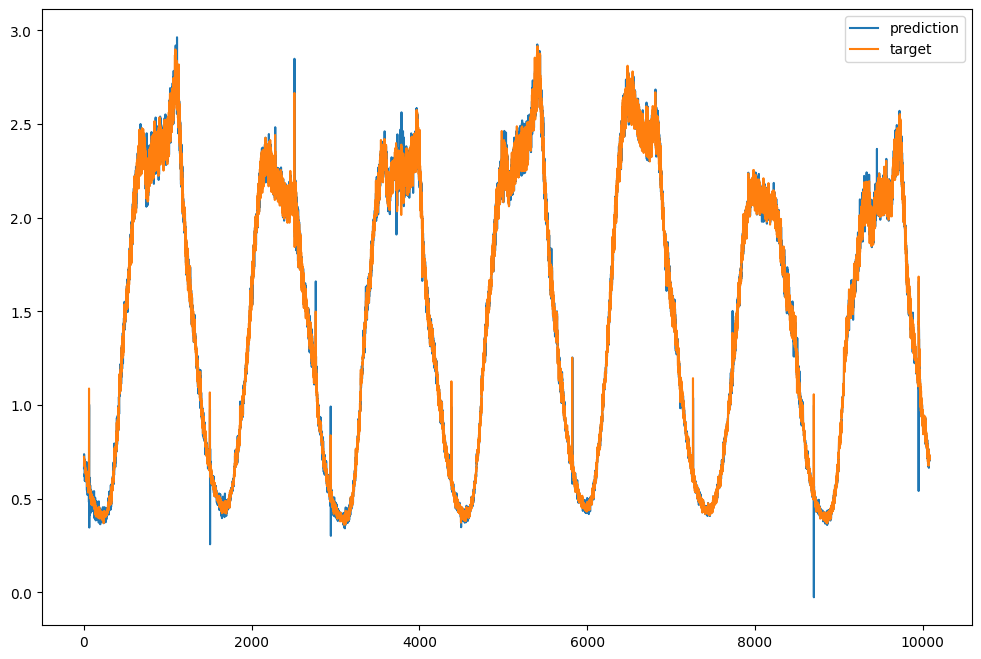

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.66334873, 0.73819816, 0.73217076, ..., 0.72949558, 0.70529574,
       0.72971785])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.72416 ],
       [0.718512],
       [0.69116 ],
       ...,
       [0.736008],
       [0.705272],
       [0.728872]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 1.9037507474422455 %
RMSE 0.04216889292001724
MAPE 1.8903432413935661 %


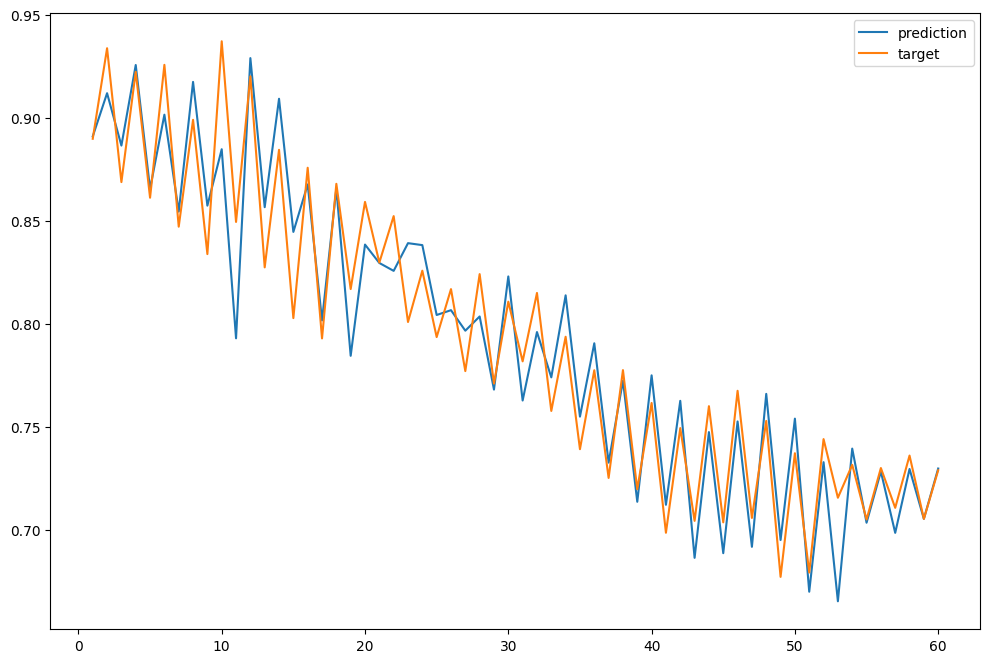

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

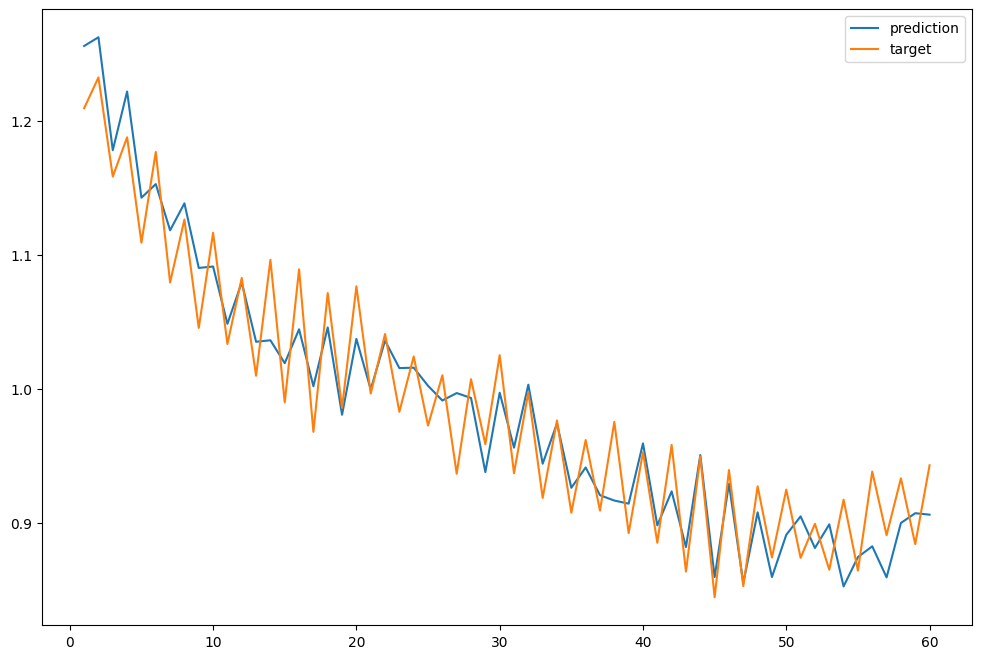

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

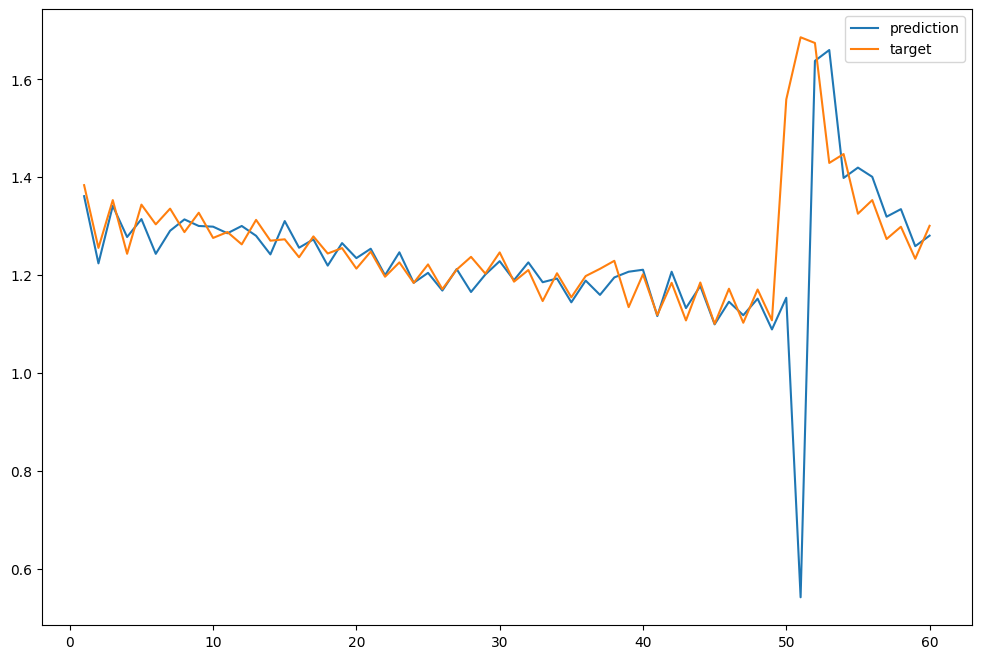

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-180:-120],label='prediction')
axes.plot(np.arange(1,61),target[-180:-120],label='target')
axes.legend()

In [28]:
len(time_list)

10080

In [29]:
np.mean(time_list) 

0.32187631693151264